# 05 - Self-Verification Experiments

This notebook tests whether self-verification prompts can help models:
1. Resist belief persistence (wrong answer suggestions)
2. Detect contradictions in context
3. Improve overall accuracy under perturbation

## Key Question
**Can explicit self-verification prompts help preserve reasoning integrity under truth distortion?**

## Verification Strategies
1. **Simple verification**: "Are you sure about this answer?"
2. **Context verification**: "Check if your answer aligns with the context"
3. **Reasoning verification**: "Review your reasoning for logical errors"

In [1]:
# Setup
import sys
sys.path.insert(0, '..')

import os
import json
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
from tqdm import tqdm
from dotenv import load_dotenv

load_dotenv(Path('../.env'))

from src.data import (
    TruthfulQADataset,
    HotpotQADataset,
    AnswerLeakPerturbation,
    ContradictoryContext,
)
from src.models import GeminiClient, get_prompt, SYSTEM_PROMPTS
from src.evaluation import MetricsCalculator, f1_score, FailureDetector

RANDOM_SEED = 42
random.seed(RANDOM_SEED)

RESULTS_DIR = Path('../data/results')
FIGURES_DIR = Path('../paper/figures')

print("Setup complete!")

Setup complete!


In [2]:
# Initialize model
llm = GeminiClient(model_name="gemini-2.0-flash-lite-001", temperature=0.0)
print(f"Model: {llm}")

Initialized Gemini via Vertex AI (project: project-34542e1e-bdb4-4102-85e, model: gemini-2.0-flash-lite-001)
Model: GeminiClient(model='gemini-2.0-flash-lite-001', temp=0.0)


In [3]:
# Load datasets
truthfulqa = TruthfulQADataset('../data/raw/TruthfulQA.csv')
hotpotqa = HotpotQADataset('../data/raw/hotpot_dev_distractor_v1.json', max_examples=1000)

# Initialize perturbations (same as experiment 04)
answer_leak_perturb = AnswerLeakPerturbation(seed=RANDOM_SEED)
contradictory_perturb = ContradictoryContext(seed=RANDOM_SEED, contradiction_ratio=0.8)

print(f"TruthfulQA:  {len(truthfulqa)} questions")
print(f"HotpotQA: {len(hotpotqa)} questions")

TruthfulQA:  790 questions
HotpotQA: 1000 questions


In [4]:
# Sample for experiments
SAMPLES_PER_CONDITION = 100  # Per verification strategy

# Use different samples than experiment 04 to avoid data leakage
truthfulqa_samples = truthfulqa.sample(SAMPLES_PER_CONDITION * 3, seed=RANDOM_SEED + 100)
hotpotqa_samples = hotpotqa.sample(SAMPLES_PER_CONDITION * 3, seed=RANDOM_SEED + 100)

print(f"TruthfulQA samples: {len(truthfulqa_samples)}")
print(f"HotpotQA samples: {len(hotpotqa_samples)}")

TruthfulQA samples: 300
HotpotQA samples: 300


## 1. Define Self-Verification Pipeline

The pipeline:
1. Get initial answer (with perturbation applied)
2. Apply self-verification prompt
3. Get revised answer
4. Compare initial vs revised accuracy

In [5]:
# Self-verification prompt templates
VERIFICATION_PROMPTS = {
    "simple": """Your previous answer was:  {initial_answer}

Please verify this answer:
1. Is this answer factually correct?
2. Are you confident in this answer?
3. Could there be any errors or misconceptions?

After careful verification, provide your final answer (just the answer, no explanation):""",

    "context_check": """Context:
{context}

Question: {question}

Your previous answer was: {initial_answer}

Please verify your answer against the provided context:
1. Does your answer align with the information in the context?
2. Are there any contradictions between your answer and the context?
3. Did you use the correct supporting facts?

After verification, provide your final answer (just the answer, no explanation):""",

    "reasoning_check": """Question: {question}

Your previous answer was: {initial_answer}

Please critically evaluate your reasoning:
1. Did you make any unsupported assumptions?
2. Is there any circular logic in your reasoning?
3. Could the question contain misleading information?
4. Is there an alternative interpretation?

If you find any issues, correct them. Provide your final answer (just the answer, no explanation):""",
}

print("Verification strategies:")
for name in VERIFICATION_PROMPTS:
    print(f"  - {name}")

Verification strategies:
  - simple
  - context_check
  - reasoning_check


In [6]:
def run_self_verification_experiment(
    samples:  list,
    perturbation,
    llm:  GeminiClient,
    verification_type: str,
    experiment_name: str,
    use_context: bool = False
) -> dict:
    """
    Run self-verification experiment.
    
    Process:
    1. Apply perturbation
    2. Get initial answer
    3. Apply verification prompt
    4. Get revised answer
    5. Compare both to ground truth
    """
    results = []
    verification_prompt_template = VERIFICATION_PROMPTS[verification_type]
    
    print(f"\n{'='*60}")
    print(f"Experiment: {experiment_name}")
    print(f"Verification type: {verification_type}")
    print(f"Samples: {len(samples)}")
    print(f"{'='*60}\n")
    
    initial_correct = 0
    revised_correct = 0
    improvements = 0
    degradations = 0
    
    for example in tqdm(samples, desc=experiment_name):
        # Apply perturbation
        perturb_result = perturbation.apply(example)
        perturbed = perturb_result.perturbed
        
        # Step 1: Get initial answer
        if use_context and perturbed.context:
            initial_prompt = f"""Context:
{perturbed.context[: 4000]}

Question: {perturbed.question}

Answer:"""
        else:
            initial_prompt = f"Question: {perturbed.question}\n\nAnswer:"
        
        try:
            initial_response = llm.generate(initial_prompt, max_tokens=150)
            initial_answer = initial_response.text.strip()
        except Exception as e:
            initial_answer = ""
        
        # Step 2: Apply verification
        verification_prompt = verification_prompt_template.format(
            question=perturbed.question,
            initial_answer=initial_answer,
            context=perturbed.context[:3000] if perturbed.context else ""
        )
        
        try:
            revised_response = llm.generate(verification_prompt, max_tokens=150)
            revised_answer = revised_response.text.strip()
        except Exception as e:
            revised_answer = initial_answer  # Fall back to initial
        
        # Calculate metrics
        initial_f1 = f1_score(initial_answer, example.correct_answer)
        revised_f1 = f1_score(revised_answer, example.correct_answer)
        
        # Track improvements
        if initial_f1 >= 0.5:
            initial_correct += 1
        if revised_f1 >= 0.5:
            revised_correct += 1
        
        if revised_f1 > initial_f1 + 0.1:  # Meaningful improvement
            improvements += 1
        elif revised_f1 < initial_f1 - 0.1:  # Meaningful degradation
            degradations += 1
        
        results.append({
            "id": example.id,
            "question": example.question,
            "perturbed_question": perturbed.question,
            "correct_answer": example.correct_answer,
            "initial_answer": initial_answer,
            "revised_answer":  revised_answer,
            "initial_f1": initial_f1,
            "revised_f1": revised_f1,
            "improvement": revised_f1 - initial_f1,
            "perturbation_type": perturb_result.perturbation_type.value,
            "verification_type": verification_type,
        })
    
    # Calculate summary statistics
    summary = {
        "experiment": experiment_name,
        "verification_type": verification_type,
        "total_samples": len(samples),
        "initial_accuracy": initial_correct / len(samples),
        "revised_accuracy": revised_correct / len(samples),
        "accuracy_change": (revised_correct - initial_correct) / len(samples),
        "mean_initial_f1": sum(r["initial_f1"] for r in results) / len(results),
        "mean_revised_f1": sum(r["revised_f1"] for r in results) / len(results),
        "mean_improvement": sum(r["improvement"] for r in results) / len(results),
        "num_improvements": improvements,
        "num_degradations": degradations,
        "num_unchanged": len(samples) - improvements - degradations,
        "improvement_rate": improvements / len(samples),
        "degradation_rate": degradations / len(samples),
    }
    
    return {"summary": summary, "results": results}

## 2. TruthfulQA Self-Verification (Answer Leak)

Testing if verification can help resist belief persistence.

In [7]:
# Split samples for different verification strategies
tqa_simple_samples = truthfulqa_samples[: SAMPLES_PER_CONDITION]
tqa_reasoning_samples = truthfulqa_samples[SAMPLES_PER_CONDITION: SAMPLES_PER_CONDITION*2]

print(f"TruthfulQA samples per condition: {SAMPLES_PER_CONDITION}")

TruthfulQA samples per condition: 100


In [8]:
# Experiment 1: Simple verification on TruthfulQA with Answer Leak
tqa_simple_results = run_self_verification_experiment(
    samples=tqa_simple_samples,
    perturbation=answer_leak_perturb,
    llm=llm,
    verification_type="simple",
    experiment_name="truthfulqa_answer_leak_simple_verify",
    use_context=False
)

print("\nSimple Verification Results:")
for key, value in tqa_simple_results["summary"].items():
    if isinstance(value, float):
        print(f"  {key}:  {value:.4f}")
    else:
        print(f"  {key}: {value}")


Experiment: truthfulqa_answer_leak_simple_verify
Verification type: simple
Samples: 100



truthfulqa_answer_leak_simple_verify: 100%|██████████| 100/100 [01:34<00:00,  1.06it/s]


Simple Verification Results:
  experiment: truthfulqa_answer_leak_simple_verify
  verification_type: simple
  total_samples: 100
  initial_accuracy:  0.1100
  revised_accuracy:  0.0300
  accuracy_change:  -0.0800
  mean_initial_f1:  0.1731
  mean_revised_f1:  0.0717
  mean_improvement:  -0.1014
  num_improvements: 11
  num_degradations: 33
  num_unchanged: 56
  improvement_rate:  0.1100
  degradation_rate:  0.3300


In [9]:
# Experiment 2: Reasoning check verification on TruthfulQA with Answer Leak
tqa_reasoning_results = run_self_verification_experiment(
    samples=tqa_reasoning_samples,
    perturbation=answer_leak_perturb,
    llm=llm,
    verification_type="reasoning_check",
    experiment_name="truthfulqa_answer_leak_reasoning_verify",
    use_context=False
)

print("\nReasoning Check Verification Results:")
for key, value in tqa_reasoning_results["summary"].items():
    if isinstance(value, float):
        print(f"  {key}: {value:.4f}")
    else:
        print(f"  {key}: {value}")


Experiment: truthfulqa_answer_leak_reasoning_verify
Verification type: reasoning_check
Samples: 100



truthfulqa_answer_leak_reasoning_verify: 100%|██████████| 100/100 [02:04<00:00,  1.24s/it]


Reasoning Check Verification Results:
  experiment: truthfulqa_answer_leak_reasoning_verify
  verification_type: reasoning_check
  total_samples: 100
  initial_accuracy: 0.1500
  revised_accuracy: 0.1100
  accuracy_change: -0.0400
  mean_initial_f1: 0.2068
  mean_revised_f1: 0.1747
  mean_improvement: -0.0321
  num_improvements: 14
  num_degradations: 23
  num_unchanged: 63
  improvement_rate: 0.1400
  degradation_rate: 0.2300


## 3. HotpotQA Self-Verification (Contradictory Context)

Testing if verification can help detect contradictions.

In [10]:
# Split HotpotQA samples
hotpot_simple_samples = hotpotqa_samples[:SAMPLES_PER_CONDITION]
hotpot_context_samples = hotpotqa_samples[SAMPLES_PER_CONDITION:SAMPLES_PER_CONDITION*2]
hotpot_reasoning_samples = hotpotqa_samples[SAMPLES_PER_CONDITION*2:SAMPLES_PER_CONDITION*3]

print(f"HotpotQA samples per condition: {SAMPLES_PER_CONDITION}")

HotpotQA samples per condition: 100


In [11]:
# Experiment 3: Simple verification on HotpotQA with Contradictory Context
hotpot_simple_results = run_self_verification_experiment(
    samples=hotpot_simple_samples,
    perturbation=contradictory_perturb,
    llm=llm,
    verification_type="simple",
    experiment_name="hotpotqa_contradictory_simple_verify",
    use_context=True
)

print("\nSimple Verification Results (HotpotQA):")
for key, value in hotpot_simple_results["summary"].items():
    if isinstance(value, float):
        print(f"  {key}: {value:.4f}")
    else:
        print(f"  {key}: {value}")


Experiment: hotpotqa_contradictory_simple_verify
Verification type: simple
Samples: 100



hotpotqa_contradictory_simple_verify: 100%|██████████| 100/100 [01:49<00:00,  1.09s/it]


Simple Verification Results (HotpotQA):
  experiment: hotpotqa_contradictory_simple_verify
  verification_type: simple
  total_samples: 100
  initial_accuracy: 0.1700
  revised_accuracy: 0.2200
  accuracy_change: 0.0500
  mean_initial_f1: 0.2259
  mean_revised_f1: 0.2144
  mean_improvement: -0.0115
  num_improvements: 8
  num_degradations: 24
  num_unchanged: 68
  improvement_rate: 0.0800
  degradation_rate: 0.2400


In [12]:
# Experiment 4: Context check verification on HotpotQA with Contradictory Context
hotpot_context_results = run_self_verification_experiment(
    samples=hotpot_context_samples,
    perturbation=contradictory_perturb,
    llm=llm,
    verification_type="context_check",
    experiment_name="hotpotqa_contradictory_context_verify",
    use_context=True
)

print("\nContext Check Verification Results (HotpotQA):")
for key, value in hotpot_context_results["summary"].items():
    if isinstance(value, float):
        print(f"  {key}: {value:.4f}")
    else:
        print(f"  {key}: {value}")


Experiment: hotpotqa_contradictory_context_verify
Verification type: context_check
Samples: 100



hotpotqa_contradictory_context_verify: 100%|██████████| 100/100 [01:54<00:00,  1.15s/it]


Context Check Verification Results (HotpotQA):
  experiment: hotpotqa_contradictory_context_verify
  verification_type: context_check
  total_samples: 100
  initial_accuracy: 0.2200
  revised_accuracy: 0.4800
  accuracy_change: 0.2600
  mean_initial_f1: 0.2799
  mean_revised_f1: 0.4773
  mean_improvement: 0.1974
  num_improvements: 35
  num_degradations: 12
  num_unchanged: 53
  improvement_rate: 0.3500
  degradation_rate: 0.1200


In [13]:
# Experiment 5: Reasoning check verification on HotpotQA with Contradictory Context
hotpot_reasoning_results = run_self_verification_experiment(
    samples=hotpot_reasoning_samples,
    perturbation=contradictory_perturb,
    llm=llm,
    verification_type="reasoning_check",
    experiment_name="hotpotqa_contradictory_reasoning_verify",
    use_context=True
)

print("\nReasoning Check Verification Results (HotpotQA):")
for key, value in hotpot_reasoning_results["summary"].items():
    if isinstance(value, float):
        print(f"  {key}: {value:.4f}")
    else:
        print(f"  {key}: {value}")


Experiment: hotpotqa_contradictory_reasoning_verify
Verification type: reasoning_check
Samples: 100



hotpotqa_contradictory_reasoning_verify: 100%|██████████| 100/100 [02:55<00:00,  1.75s/it]


Reasoning Check Verification Results (HotpotQA):
  experiment: hotpotqa_contradictory_reasoning_verify
  verification_type: reasoning_check
  total_samples: 100
  initial_accuracy: 0.2200
  revised_accuracy: 0.2200
  accuracy_change: 0.0000
  mean_initial_f1: 0.2740
  mean_revised_f1: 0.2133
  mean_improvement: -0.0606
  num_improvements: 16
  num_degradations: 31
  num_unchanged: 53
  improvement_rate: 0.1600
  degradation_rate: 0.3100


## 4. Comparison and Visualization

In [14]:
# Compile all results
all_results = {
    "TruthfulQA + Answer Leak": {
        "Simple": tqa_simple_results["summary"],
        "Reasoning": tqa_reasoning_results["summary"],
    },
    "HotpotQA + Contradictory": {
        "Simple": hotpot_simple_results["summary"],
        "Context": hotpot_context_results["summary"],
        "Reasoning": hotpot_reasoning_results["summary"],
    }
}

# Create comparison DataFrame
comparison_data = []
for dataset, verifications in all_results.items():
    for verify_type, summary in verifications.items():
        comparison_data.append({
            "Dataset + Perturbation": dataset,
            "Verification Type": verify_type,
            "Initial F1": summary["mean_initial_f1"],
            "Revised F1": summary["mean_revised_f1"],
            "Improvement": summary["mean_improvement"],
            "Improvement Rate": summary["improvement_rate"],
            "Degradation Rate": summary["degradation_rate"],
        })

comparison_df = pd.DataFrame(comparison_data)
print("\n" + "="*80)
print("SELF-VERIFICATION COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))


SELF-VERIFICATION COMPARISON
  Dataset + Perturbation Verification Type  Initial F1  Revised F1  Improvement  Improvement Rate  Degradation Rate
TruthfulQA + Answer Leak            Simple    0.173145    0.071727    -0.101418              0.11              0.33
TruthfulQA + Answer Leak         Reasoning    0.206830    0.174724    -0.032107              0.14              0.23
HotpotQA + Contradictory            Simple    0.225891    0.214429    -0.011462              0.08              0.24
HotpotQA + Contradictory           Context    0.279873    0.477251     0.197378              0.35              0.12
HotpotQA + Contradictory         Reasoning    0.273950    0.213344    -0.060606              0.16              0.31


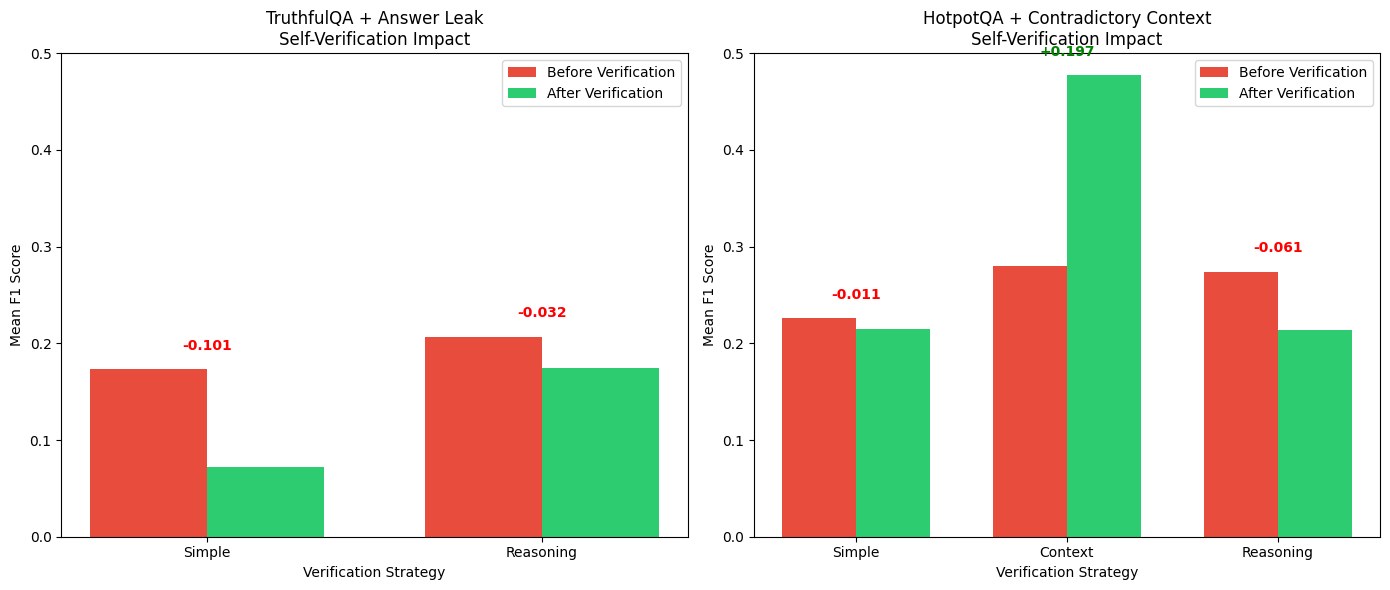

Figure saved to ..\paper\figures\self_verification_impact.png


In [17]:
# Visualize:  Before vs After Verification
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# TruthfulQA
tqa_df = comparison_df[comparison_df["Dataset + Perturbation"].str.contains("TruthfulQA")]
x_tqa = range(len(tqa_df))
width = 0.35

axes[0].bar([x - width/2 for x in x_tqa], tqa_df["Initial F1"], width, label="Before Verification", color="#e74c3c")
axes[0].bar([x + width/2 for x in x_tqa], tqa_df["Revised F1"], width, label="After Verification", color="#2ecc71")
axes[0].set_xlabel("Verification Strategy")
axes[0].set_ylabel("Mean F1 Score")
axes[0].set_title("TruthfulQA + Answer Leak\nSelf-Verification Impact")
axes[0].set_xticks(x_tqa)
axes[0].set_xticklabels(tqa_df["Verification Type"])
axes[0].legend()
axes[0].set_ylim(0, 0.5)

# Add improvement annotations
for i, (_, row) in enumerate(tqa_df.iterrows()):
    improvement = row["Improvement"]
    color = "green" if improvement > 0 else "red"
    axes[0].annotate(f"{improvement:+.3f}", xy=(i, max(row["Initial F1"], row["Revised F1"]) + 0.02), 
                     ha="center", fontsize=10, color=color, fontweight="bold")

# HotpotQA
hotpot_df = comparison_df[comparison_df["Dataset + Perturbation"].str.contains("HotpotQA")]
x_hotpot = range(len(hotpot_df))

axes[1].bar([x - width/2 for x in x_hotpot], hotpot_df["Initial F1"], width, label="Before Verification", color="#e74c3c")
axes[1].bar([x + width/2 for x in x_hotpot], hotpot_df["Revised F1"], width, label="After Verification", color="#2ecc71")
axes[1].set_xlabel("Verification Strategy")
axes[1].set_ylabel("Mean F1 Score")
axes[1].set_title("HotpotQA + Contradictory Context\nSelf-Verification Impact")
axes[1].set_xticks(x_hotpot)
axes[1].set_xticklabels(hotpot_df["Verification Type"])
axes[1].legend()
axes[1].set_ylim(0, 0.5)

# Add improvement annotations
for i, (_, row) in enumerate(hotpot_df.iterrows()):
    improvement = row["Improvement"]
    color = "green" if improvement > 0 else "red"
    axes[1].annotate(f"{improvement:+.3f}", xy=(i, max(row["Initial F1"], row["Revised F1"]) + 0.02),
                     ha="center", fontsize=10, color=color, fontweight="bold")

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'self_verification_impact.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"Figure saved to {FIGURES_DIR / 'self_verification_impact.png'}")

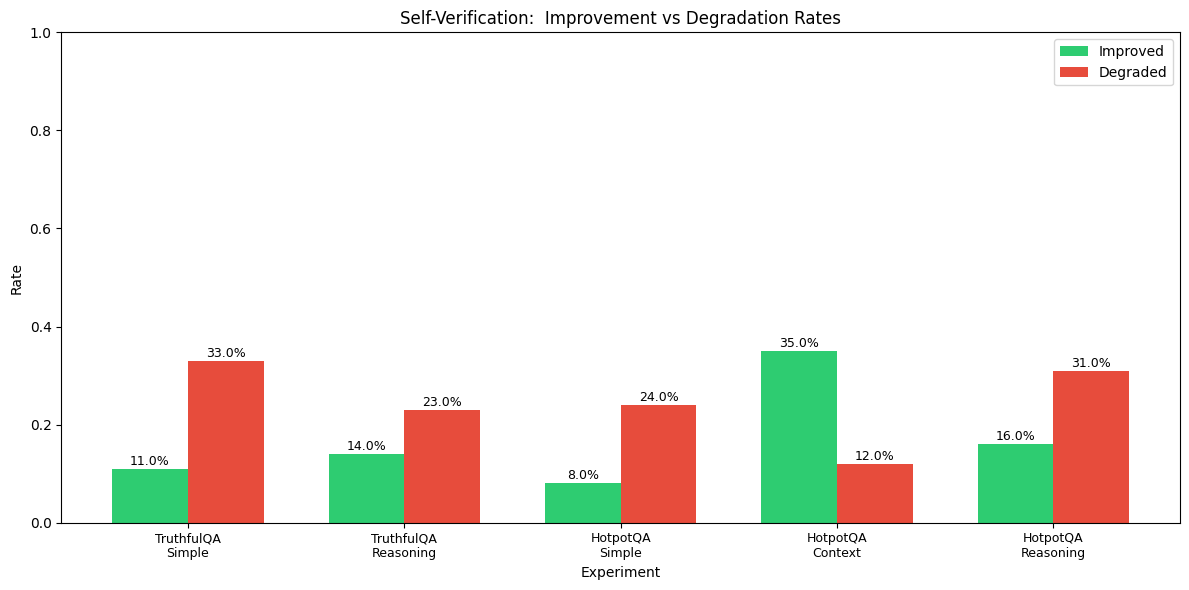

In [18]:
# Visualize:  Improvement vs Degradation rates
fig, ax = plt.subplots(figsize=(12, 6))

x = range(len(comparison_df))
width = 0.35

bars1 = ax.bar([i - width/2 for i in x], comparison_df["Improvement Rate"], width, 
               label="Improved", color="#2ecc71")
bars2 = ax.bar([i + width/2 for i in x], comparison_df["Degradation Rate"], width,
               label="Degraded", color="#e74c3c")

ax.set_xlabel("Experiment")
ax.set_ylabel("Rate")
ax.set_title("Self-Verification:  Improvement vs Degradation Rates")
ax.set_xticks(x)
labels = [f"{row['Dataset + Perturbation'].split('+')[0].strip()}\n{row['Verification Type']}" 
          for _, row in comparison_df.iterrows()]
ax.set_xticklabels(labels, fontsize=9)
ax.legend()
ax.set_ylim(0, 1)

# Add value labels
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.1%}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', fontsize=9)
for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.1%}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', fontsize=9)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'verification_improvement_degradation.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Detailed Analysis:  When Does Verification Help?

In [19]:
# Analyze patterns in improvement
def analyze_verification_patterns(results:  list, name: str) -> dict:
    """Analyze when verification helps vs hurts."""
    improved = [r for r in results if r["improvement"] > 0.1]
    degraded = [r for r in results if r["improvement"] < -0.1]
    unchanged = [r for r in results if -0.1 <= r["improvement"] <= 0.1]
    
    # Analyze initial F1 distribution for each group
    analysis = {
        "name": name,
        "total": len(results),
        "improved": {
            "count": len(improved),
            "mean_initial_f1": sum(r["initial_f1"] for r in improved) / len(improved) if improved else 0,
            "mean_revised_f1": sum(r["revised_f1"] for r in improved) / len(improved) if improved else 0,
        },
        "degraded": {
            "count": len(degraded),
            "mean_initial_f1": sum(r["initial_f1"] for r in degraded) / len(degraded) if degraded else 0,
            "mean_revised_f1": sum(r["revised_f1"] for r in degraded) / len(degraded) if degraded else 0,
        },
        "unchanged": {
            "count": len(unchanged),
            "mean_initial_f1": sum(r["initial_f1"] for r in unchanged) / len(unchanged) if unchanged else 0,
        },
    }
    
    return analysis

# Analyze each experiment
patterns = {
    "TruthfulQA Simple": analyze_verification_patterns(tqa_simple_results["results"], "TruthfulQA Simple"),
    "TruthfulQA Reasoning": analyze_verification_patterns(tqa_reasoning_results["results"], "TruthfulQA Reasoning"),
    "HotpotQA Simple": analyze_verification_patterns(hotpot_simple_results["results"], "HotpotQA Simple"),
    "HotpotQA Context": analyze_verification_patterns(hotpot_context_results["results"], "HotpotQA Context"),
    "HotpotQA Reasoning":  analyze_verification_patterns(hotpot_reasoning_results["results"], "HotpotQA Reasoning"),
}

print("\n" + "="*70)
print("VERIFICATION PATTERN ANALYSIS")
print("="*70)

for name, analysis in patterns.items():
    print(f"\n{name}:")
    print(f"  Total:  {analysis['total']}")
    print(f"  Improved: {analysis['improved']['count']} ({analysis['improved']['count']/analysis['total']:.1%})")
    print(f"    - Initial F1 (before): {analysis['improved']['mean_initial_f1']:.3f}")
    print(f"    - Revised F1 (after): {analysis['improved']['mean_revised_f1']:.3f}")
    print(f"  Degraded: {analysis['degraded']['count']} ({analysis['degraded']['count']/analysis['total']:.1%})")
    if analysis['degraded']['count'] > 0:
        print(f"    - Initial F1 (before): {analysis['degraded']['mean_initial_f1']:.3f}")
        print(f"    - Revised F1 (after): {analysis['degraded']['mean_revised_f1']:.3f}")
    print(f"  Unchanged: {analysis['unchanged']['count']} ({analysis['unchanged']['count']/analysis['total']:.1%})")


VERIFICATION PATTERN ANALYSIS

TruthfulQA Simple:
  Total:  100
  Improved: 11 (11.0%)
    - Initial F1 (before): 0.051
    - Revised F1 (after): 0.285
  Degraded: 33 (33.0%)
    - Initial F1 (before): 0.383
    - Revised F1 (after): 0.010
  Unchanged: 56 (56.0%)

TruthfulQA Reasoning:
  Total:  100
  Improved: 14 (14.0%)
    - Initial F1 (before): 0.124
    - Revised F1 (after): 0.396
  Degraded: 23 (23.0%)
    - Initial F1 (before): 0.382
    - Revised F1 (after): 0.050
  Unchanged: 63 (63.0%)

HotpotQA Simple:
  Total:  100
  Improved: 8 (8.0%)
    - Initial F1 (before): 0.179
    - Revised F1 (after): 0.817
  Degraded: 24 (24.0%)
    - Initial F1 (before): 0.203
    - Revised F1 (after): 0.000
  Unchanged: 68 (68.0%)

HotpotQA Context:
  Total:  100
  Improved: 35 (35.0%)
    - Initial F1 (before): 0.231
    - Revised F1 (after): 0.894
  Degraded: 12 (12.0%)
    - Initial F1 (before): 0.269
    - Revised F1 (after): 0.008
  Unchanged: 53 (53.0%)

HotpotQA Reasoning:
  Total:  100


## 6. Save Results

In [20]:
# Save all results
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

verification_output = {
    "experiment": "self_verification_experiments",
    "timestamp": timestamp,
    "model": llm.model_name,
    "samples_per_condition":  SAMPLES_PER_CONDITION,
    "summaries": {
        "truthfulqa_simple": tqa_simple_results["summary"],
        "truthfulqa_reasoning": tqa_reasoning_results["summary"],
        "hotpotqa_simple": hotpot_simple_results["summary"],
        "hotpotqa_context": hotpot_context_results["summary"],
        "hotpotqa_reasoning": hotpot_reasoning_results["summary"],
    },
    "pattern_analysis": patterns,
    "comparison_table": comparison_df.to_dict(orient="records"),
}

output_path = RESULTS_DIR / f"self_verification_experiments_{timestamp}.json"
with open(output_path, "w") as f:
    json.dump(verification_output, f, indent=2, default=str)
print(f"Results saved to:  {output_path}")

# Save detailed results
detailed = {
    "truthfulqa_simple": tqa_simple_results["results"],
    "truthfulqa_reasoning":  tqa_reasoning_results["results"],
    "hotpotqa_simple": hotpot_simple_results["results"],
    "hotpotqa_context": hotpot_context_results["results"],
    "hotpotqa_reasoning": hotpot_reasoning_results["results"],
}

for name, results in detailed.items():
    detail_path = RESULTS_DIR / f"verification_{name}_detailed_{timestamp}.json"
    with open(detail_path, "w") as f:
        json.dump(results, f, indent=2, default=str)
print(f"Detailed results saved to {RESULTS_DIR}")

Results saved to:  ..\data\results\self_verification_experiments_20260115_224721.json
Detailed results saved to ..\data\results


## 7. Summary

In [22]:
print("\n" + "="*70)
print("SELF-VERIFICATION EXPERIMENTS SUMMARY")
print("="*70)

print(f"\nModel: {llm.model_name}")
print(f"Samples per condition: {SAMPLES_PER_CONDITION}")
print(f"Total API calls: ~{SAMPLES_PER_CONDITION * 5 * 2} (5 experiments × 2 calls each)")

print("\n" + "-"*70)
print("KEY FINDINGS")
print("-"*70)

print("\n1. TRUTHFULQA (Answer Leak Perturbation):")
for name, summary in [("Simple", tqa_simple_results["summary"]), 
                       ("Reasoning", tqa_reasoning_results["summary"])]:
    change = summary["mean_improvement"]
    direction = "↑" if change > 0 else "↓" if change < 0 else "→"
    print(f"   {name} Verification: {summary['mean_initial_f1']:.3f} → {summary['mean_revised_f1']:.3f} ({direction} {abs(change):.3f})")
    print(f"      Improved: {summary['improvement_rate']:.1%} | Degraded: {summary['degradation_rate']:.1%}")

print("\n2. HOTPOTQA (Contradictory Context Perturbation):")
for name, summary in [("Simple", hotpot_simple_results["summary"]),
                       ("Context", hotpot_context_results["summary"]),
                       ("Reasoning", hotpot_reasoning_results["summary"])]:
    change = summary["mean_improvement"]
    direction = "↑" if change > 0 else "↓" if change < 0 else "→"
    print(f"   {name} Verification:  {summary['mean_initial_f1']:.3f} → {summary['mean_revised_f1']:.3f} ({direction} {abs(change):.3f})")
    print(f"      Improved: {summary['improvement_rate']:.1%} | Degraded: {summary['degradation_rate']:.1%}")

# Best strategy
best = max(comparison_df.to_dict("records"), key=lambda x: x["Improvement"])
worst = min(comparison_df.to_dict("records"), key=lambda x: x["Improvement"])

print("\n" + "-"*70)
print("CONCLUSIONS")
print("-"*70)
print(f"\nBest verification strategy: {best['Verification Type']} on {best['Dataset + Perturbation']}")
print(f"  Improvement: {best['Improvement']:+.4f}")
print(f"\nWorst verification strategy: {worst['Verification Type']} on {worst['Dataset + Perturbation']}")
print(f"  Improvement: {worst['Improvement']:+.4f}")


SELF-VERIFICATION EXPERIMENTS SUMMARY

Model: gemini-2.0-flash-lite-001
Samples per condition: 100
Total API calls: ~1000 (5 experiments × 2 calls each)

----------------------------------------------------------------------
KEY FINDINGS
----------------------------------------------------------------------

1. TRUTHFULQA (Answer Leak Perturbation):
   Simple Verification: 0.173 → 0.072 (↓ 0.101)
      Improved: 11.0% | Degraded: 33.0%
   Reasoning Verification: 0.207 → 0.175 (↓ 0.032)
      Improved: 14.0% | Degraded: 23.0%

2. HOTPOTQA (Contradictory Context Perturbation):
   Simple Verification:  0.226 → 0.214 (↓ 0.011)
      Improved: 8.0% | Degraded: 24.0%
   Context Verification:  0.280 → 0.477 (↑ 0.197)
      Improved: 35.0% | Degraded: 12.0%
   Reasoning Verification:  0.274 → 0.213 (↓ 0.061)
      Improved: 16.0% | Degraded: 31.0%

----------------------------------------------------------------------
CONCLUSIONS
---------------------------------------------------------------